# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# IMPORTS

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from sklearn.preprocessing import Normalizer #L2 norm
from sklearn.preprocessing import StandardScaler# z= (x-mean)/sigma

In [4]:
from scipy.sparse import hstack

In [5]:
from sklearn.model_selection import RandomizedSearchCV

In [6]:
from sklearn.naive_bayes import MultinomialNB

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

In [8]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [9]:
import matplotlib.pyplot as plt

In [74]:
def vectorizer(df_train,df_test,name,vect):
    train = vect.fit_transform(df_train[name])
    test = vect.transform(df_test[name])
    return train,test,vect
def vecotizer2d(df_train,df_test,name,vect):
    train = vect.fit_transform(df_train[name].values.reshape(-1,1))
    test = vect.transform(df_test[name].values.reshape(-1,1))
    return train , test, vect
def plotAucAllHyperParameter(plot_data):
    x = [ s['alpha'] for s in plot_data['params']]
    y_test = plot_data['mean_test_score']
    y_train = plot_data['mean_train_score']
    plt.plot(x,y_train,label="Train",color='blue')
    plt.plot(x,y_test,label="Test",color='red')
    plt.xlabel("Hyper parameter alpha -->")
    plt.ylabel("ROC AUC -->")
    plt.legend()
    plt.show()

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [11]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)
project_data = pd.read_csv('preprocessed_data.csv')
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 9)
--------------------------------------------------
The attributes of data : ['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price']


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [12]:
k = list(project_data.columns.values)
k.remove('project_is_approved')
# Making input X and output Y 
X = project_data[k]
y = project_data['project_is_approved']

In [13]:
# write your code in following steps for task 1
# 1. Split your data.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)
#as I will be performing randomsearchCV no validation set

## 1.3 Featueizing essay

In [14]:
# 2. Perform Bag of Words Vectorization of text data.
train_bow,test_bow,model_bow = vectorizer(X_train,X_test,'essay',CountVectorizer(ngram_range=(1,2)))

In [15]:
print("Train BOW shape",train_bow.shape,"Test BOW : ",test_bow.shape)

Train BOW shape (87398, 2267042) Test BOW :  (21850, 2267042)


In [16]:
# 3. Perform tfidf vectorization of text data
train_tfid,test_tfid,model_tfid = vectorizer(X_train,X_test,'essay',TfidfVectorizer(ngram_range=(1,2)))

In [17]:
print("Train BOW shape",train_tfid.shape,"Test BOW : ",test_tfid.shape)

Train BOW shape (87398, 2267042) Test BOW :  (21850, 2267042)


<h1 style="color:red"> Apply TF-IDF vectorization on 'Preprocessed_Title' <h1>

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [18]:
# 4. perform one-hot encoding of categorical features.
# 'school_state', 'teacher_prefix', 'project_grade_category','clean_categories','clean_subcategories'
train_state,test_state,model_state = vectorizer(X_train,X_test,'school_state',CountVectorizer(binary=True))
train_prefic, test_prefix,model_prefix = vectorizer(X_train,X_test,'teacher_prefix',CountVectorizer(binary=True))
train_grade, test_grade,model_grade = vectorizer(X_train,X_test,'project_grade_category',CountVectorizer(binary=True))
trian_cat, test_cat,model_cat = vectorizer(X_train,X_test,'clean_categories',CountVectorizer(binary=True))
train_sub, test_sub,model_sub = vectorizer(X_train,X_test,'clean_subcategories',CountVectorizer(binary=True))

In [19]:
# 5. perform normalization of numerical features
# price , teacher_number_of_previously_posted_projects

# We are not using standard scalar because 
train_price,test_price,model_price = vecotizer2d(X_train,X_test,'price',Normalizer())
train_prev_posted, test_prev_posted,model_prev_posted = vecotizer2d(X_train, X_test,'teacher_number_of_previously_posted_projects',Normalizer())

In [20]:
print(train_bow.shape,train_state.shape,train_prefic.shape,train_grade.shape,trian_cat.shape,train_sub.shape,train_price.shape,train_prev_posted.shape)

(87398, 2267042) (87398, 51) (87398, 5) (87398, 4) (87398, 9) (87398, 30) (87398, 1) (87398, 1)


### Constructing a single featue vector

In [21]:
# 6. For set 1 stack up all the features using hstack()
train_set1 = hstack((train_bow,train_state,train_prefic,train_grade,trian_cat,train_sub,train_price,train_prev_posted))
test_set1 = hstack((test_bow,test_state,test_prefix,test_grade,test_cat,test_sub,test_price,test_prev_posted))
# 7. For set 2 stack up all the features using hstack()
train_set2= hstack((train_tfid,train_state,train_prefic,train_grade,trian_cat,train_sub,train_price,train_prev_posted))
test_set2 = hstack((test_tfid ,test_state,test_prefix,test_grade,test_cat,test_sub,test_price,test_prev_posted))

 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.


 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)



 10. Plot confusion matrix based on the best threshold value



 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.



 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 



13. You can use Prettytable or any other tabular format for comparison.


please write all the code with proper documentation, and proper titles for each subsection
go through documentations and blogs before you start coding
first figure out what to do, and then think about how to do.
reading and understanding error messages will be very much helpfull in debugging your code
when you plot any graph make sure you use 
    a. Title, that describes your plot, this will be very helpful to the reader
    b. Legends if needed
    c. X-axis label
    d. Y-axis label


 Split the dataset 
 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)



<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

# Set 1

In [67]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
from sklearn.model_selection import GridSearchCV
hp_space = {"alpha":[0.01,0.05,0.1,0.2,0.5,1]}
mnb = MultinomialNB()
gs = GridSearchCV(mnb,n_jobs=5,param_grid=hp_space,scoring='roc_auc',cv=5,return_train_score=True)

In [68]:
gs.fit(train_set1,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=5,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1]},
             return_train_score=True, scoring='roc_auc')

In [69]:
print("Optimal Hyperparameter is : ",gs.best_params_)

Optimal Hyperparameter is :  {'alpha': 0.1}


#### as 1 was at the corner of the grid of the hyper parameter we will check in the values around 1 which are less then 1

In [70]:
# hp_space = {"alpha":[0.01,0.1,0.5,1]}
# mnb = MultinomialNB()
# gs = GridSearchCV(mnb,n_jobs=5,param_grid=hp_space,scoring='roc_auc',cv=5,return_train_score=True)
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.

In [71]:
# gs.fit(train_set1,y_train)

In [72]:
# print("Optimal Hyperparameter is : ",gs.best_params_)
gs.cv_results_

{'mean_fit_time': array([1.0948586 , 1.32178893, 1.14404993, 1.2185461 , 1.12848067,
        1.03260908]),
 'std_fit_time': array([0.1172158 , 0.23248384, 0.2391839 , 0.10358867, 0.25141538,
        0.20631611]),
 'mean_score_time': array([0.2142941 , 0.21411157, 0.18514829, 0.2015872 , 0.18193583,
        0.16450701]),
 'std_score_time': array([0.0460716 , 0.03758066, 0.04314957, 0.02870431, 0.04091065,
        0.05050036]),
 'param_alpha': masked_array(data=[0.01, 0.05, 0.1, 0.2, 0.5, 1],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01},
  {'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.2},
  {'alpha': 0.5},
  {'alpha': 1}],
 'split0_test_score': array([0.6213128 , 0.63789866, 0.64004384, 0.63678358, 0.60661995,
        0.52849891]),
 'split1_test_score': array([0.61433923, 0.63226507, 0.6327752 , 0.62869296, 0.59778922,
        0.522155  ]),
 'split2_test_score': array([0.62533118, 0.63503

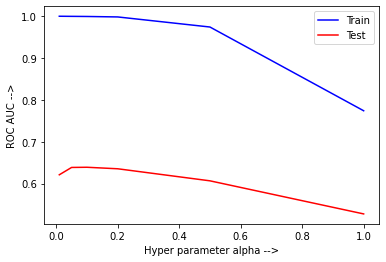

In [73]:
plotAucAllHyperParameter(gs.cv_results_)
# Making the model with the best parameters 

In [29]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
bestmnb = MultinomialNB(alpha=gs.best_params_)
bestmnb.fit(train_set1,y_train)

MultinomialNB(alpha=0.1)

In [30]:
y_pred_test = bestmnb.predict_proba(test_set1)
y_pred_train = bestmnb.predict_proba(train_set1)

In [31]:
print(y_test.shape)
print(y_pred_test[:,1].shape)

(21850,)
(21850,)


In [32]:
test = roc_curve(y_test, y_pred_test[:,1])# this returns a list which is the order of [false_postive_rate,true_positive_rate,thresholds]
train = roc_curve(y_train,y_pred_train[:,1])
print("TEST AUC SCORE",roc_auc_score(y_test, y_pred_test[:,1]))

TEST AUC SCORE 0.6533980764868985


In [33]:
opt = [ (1-test[0][i])*(test[1][i]) for i in range(len(test[0]))]
optimal_theta = opt[opt.index(max(opt))]

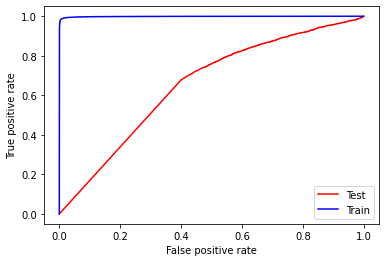

In [34]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
plt.plot(test[0],test[1],label="Test",color='red')
plt.plot(train[0],train[1],label="Train",color='blue')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

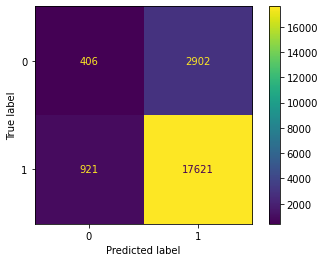

In [35]:
predicted = y_pred_test[:,1]
predicted[predicted>optimal_theta] = 1
predicted[predicted<= optimal_theta] = 0
matrix = confusion_matrix(y_test,predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

In [36]:
def topKfretures_indices(model,class_,k):
    max_index = np.argpartition(model.feature_log_prob_[class_], -k)[-k:]# Less the probality values the more negative the log value would be
    return max_index
def printTopKfeatur(model,class_,c):
    indices = topKfretures_indices(model,class_,c)
    featur_index = [train_bow.shape,train_state.shape,train_prefic.shape,train_grade.shape,
                    trian_cat.shape,train_sub.shape,train_price.shape,train_prev_posted.shape]
    mapp =  {0:'_wordE',1:'_state',2:'_prefic',3:'_grade',4:'_cat',5:'_sub',
             6:'_price',7:'_prev_posted'}
    models = {'_wordE':model_bow, '_state':model_state ,'_prefic':model_prefix ,
              '_grade':model_grade ,'_cat':model_cat,'_sub':model_sub,
             '_price':model_price,'_prev_posted':model_prev_posted}
    
    index_mapp = {}
    caps = []
    summ = 0 
    for i in range(len(featur_index)):
        summ += featur_index[i][1]
        index_mapp[summ]=mapp[i]
        caps.append(summ)
    #print(caps)
    inv_mapp = list(index_mapp.keys())
    count=0
    for i in indices:
        found = False
        count+=1
        for k in range(len(inv_mapp)-2):

            if i<inv_mapp[k]:
                found = True
                #print(i,inv_mapp[k],index_mapp[inv_mapp[k]])
                class_num = k
                model_index = i# index in full vector space
                if class_num>0:
                    model_index=model_index - caps[class_num-1]-1
                # print(model_index)
                # print(models[mapp[k]].vocabulary_.items())
                for i in models[mapp[k]].vocabulary_.items():
                    if i[1]==model_index:
                        print(count,". ",i[0])
                        break
                break
        if not found:
            if i<caps[-2]:
                print(count,". ",'_price')
            elif i < caps[-1]:
                print(count,". ",'_prev_posted')
print("Top featurs that contributed to the Negative class: ")
printTopKfeatur(bestmnb,0,20)
print(20*"#"+"\n"+20*"#")
print("Top featurs that contributed to the Positive class: ")
printTopKfeatur(bestmnb,1,20)

Top featurs that contributed to the Negative class: 
1 .  love
2 .  _prev_posted
3 .  school
4 .  not
5 .  come
6 .  help
7 .  they
8 .  students
9 .  we
10 .  learn
11 .  learning
12 .  my
13 .  many
14 .  the
15 .  my students
16 .  nannan
17 .  need
18 .  work
19 .  _price
20 .  classroom
####################
####################
Top featurs that contributed to the Positive class: 
1 .  _prev_posted
2 .  many
3 .  work
4 .  learning
5 .  learn
6 .  help
7 .  my
8 .  my students
9 .  need
10 .  not
11 .  we
12 .  reading
13 .  school
14 .  students
15 .  classroom
16 .  the
17 .  they
18 .  use
19 .  _price
20 .  nannan


# Set 2

In [82]:
hp_space = {"alpha":[0.0001,0.0005,0.001,0.005,0.01,0.1,0.5,1]}
mnb = MultinomialNB()
gs = GridSearchCV(mnb,n_jobs=5,param_grid=hp_space,scoring='roc_auc',cv=5,return_train_score=True)
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
gs.fit(train_set2,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=5,
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.5,
                                   1]},
             return_train_score=True, scoring='roc_auc')

In [83]:
gs.best_params_

{'alpha': 0.001}

In [84]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.
# hp_space = {"alpha":[0.00001,0.0001,0.001]}
# mnb = MultinomialNB()
# gs = GridSearchCV(mnb,n_jobs=10,param_grid=hp_space,scoring='roc_auc',cv=5,return_train_score=True)
# gs.fit(train_set2,y_train)
# gs.best_params_

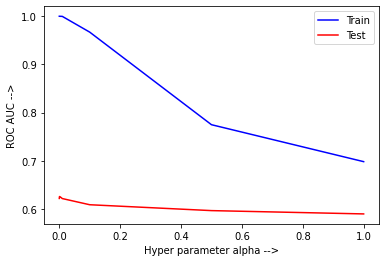

In [85]:
plotAucAllHyperParameter(gs.cv_results_)

In [86]:
bestmnb2 = MultinomialNB(alpha=gs.best_params_['alpha'])
bestmnb2.fit(train_set2,y_train)

MultinomialNB(alpha=0.001)

In [41]:
train_set2.shape

(87398, 2267143)

In [42]:
test_set2.shape

(21850, 2267143)

In [43]:
y_pred_test = bestmnb2.predict_proba(test_set2)
y_pred_train = bestmnb2.predict_proba(train_set2)

In [44]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
test = roc_curve(y_test, y_pred_test[:,1])# this returns a list which is the order of [false_postive_rate,true_positive_rate,thresholds]
train = roc_curve(y_train,y_pred_train[:,1])
print("TEST AUC SCORE",roc_auc_score(y_test, y_pred_test[:,1]))

TEST AUC SCORE 0.6320794211174814


In [45]:
opt = [ (1-test[0][i])*(test[1][i]) for i in range(len(test[0]))]

In [46]:
optimal_theta = opt[opt.index(max(opt))]
print("Optimal Theta set 2: ",optimal_theta)

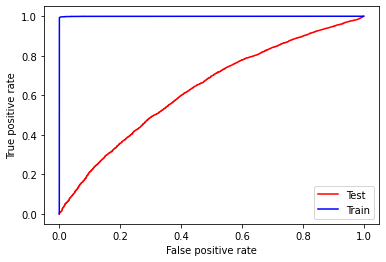

In [47]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
plt.plot(test[0],test[1],label="Test",color='red')
plt.plot(train[0],train[1],label="Train",color='blue')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

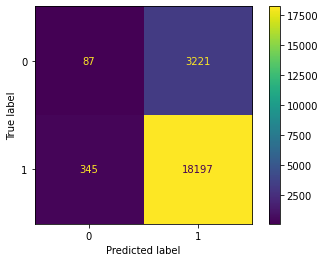

In [48]:
predicted = y_pred_test[:,1]
predicted[predicted>optimal_theta] = 1
predicted[predicted<= optimal_theta] = 0
matrix = confusion_matrix(y_test,predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

In [49]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)
# class 0 --> negative ,  class 1 ---> positive


In [50]:
def printTopKfeatur(model,class_,c):
    indices = topKfretures_indices(model,class_,c)
    featur_index = [train_tfid.shape,train_state.shape,train_prefic.shape,train_grade.shape,
                    trian_cat.shape,train_sub.shape,train_price.shape,train_prev_posted.shape]
    mapp =  {0:'_wordE',1:'_state',2:'_prefic',3:'_grade',4:'_cat',5:'_sub',
             6:'_price',7:'_prev_posted'}
    models = {'_wordE':model_tfid, '_state':model_state ,'_prefic':model_prefix ,
              '_grade':model_grade ,'_cat':model_cat,'_sub':model_sub,
             '_price':model_price,'_prev_posted':model_prev_posted}
    
    index_mapp = {}
    caps = []
    summ = 0 
    for i in range(len(featur_index)):
        summ += featur_index[i][1]
        index_mapp[summ]=mapp[i]
        caps.append(summ)
    #print(caps)
    inv_mapp = list(index_mapp.keys())
    count=0
    for i in indices:
        found = False
        count+=1
        for k in range(len(inv_mapp)-2):

            if i<inv_mapp[k]:
                found = True
                #print(i,inv_mapp[k],index_mapp[inv_mapp[k]])
                class_num = k
                model_index = i# index in full vector space
                if class_num>0:
                    model_index=model_index - caps[class_num-1]-1
                # print(model_index)
                # print(models[mapp[k]].vocabulary_.items())
                for i in models[mapp[k]].vocabulary_.items():
                    if i[1]==model_index:
                        print(count,". ",i[0])
                        break
                break
        if not found:
            if i<caps[-2]:
                print(count,". ",'_price')
            elif i < caps[-1]:
                print(count,". ",'_prev_posted')
print("Top featurs that contributed to the Negative class: ")
printTopKfeatur(bestmnb2,0,20)
print("Top featurs that contributed to the Positive class: ")
printTopKfeatur(bestmnb2,1,20)

Top featurs that contributed to the Negative class: 
1 .  dr
2 .  grades_6_8
4 .  music_arts
5 .  grades_3_5
6 .  history_geography
7 .  literacy
8 .  literature_writing
10 .  care_hunger
11 .  socialsciences
12 .  az
14 .  mrs
15 .  literacy_language
16 .  history_civics
17 .  grades_9_12
18 .  mr
19 .  _price
20 .  _prev_posted
Top featurs that contributed to the Positive class: 
2 .  dr
3 .  grades_6_8
4 .  grades_9_12
5 .  grades_3_5
6 .  music_arts
7 .  literacy
8 .  literature_writing
10 .  mrs
11 .  az
13 .  care_hunger
14 .  history_civics
15 .  socialsciences
16 .  literacy_language
17 .  history_geography
18 .  mr
19 .  _price
20 .  _prev_posted


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions
Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
 You can either use a pretty table or any other tabular structure.
 Reference Link for Pretty table:  https://pypi.org/project/prettytable/

 <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>

In [54]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]
x.add_row(["BOW","Multinomial Naiye Bayse", 0.1, 0.6533980])
x.add_row(["TFIDF", "Multinomial Naiye Bayse", 0.001, 0.63207])
print(x)

+------------+-------------------------+-----------------+----------+
| Vectorizer |          Model          | Hyper Parameter |   AUC    |
+------------+-------------------------+-----------------+----------+
|    BOW     | Multinomial Naiye Bayse |       0.1       | 0.653398 |
|   TFIDF    | Multinomial Naiye Bayse |      0.001      | 0.63207  |
+------------+-------------------------+-----------------+----------+
